In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 100ms/step - loss: 0.0352 - val_loss: 0.0137
Epoch 2/100
16/16 [==============================] - 1s 81ms/step - loss: 0.0082 - val_loss: 8.9521e-04
Epoch 3/100
16/16 [==============================] - 1s 81ms/step - loss: 0.0019 - val_loss: 8.4907e-04
Epoch 4/100
16/16 [==============================] - 1s 83ms/step - loss: 7.4147e-04 - val_loss: 5.1569e-04
Epoch 5/100
16/16 [==============================] - 1s 86ms/step - loss: 6.0170e-04 - val_loss: 4.2318e-04
Epoch 6/100
16/16 [==============================] - 1s 51ms/step - loss: 5.3850e-04 - val_loss: 4.2907e-04
Epoch 7/100
16/16 [==============================] - 1s 49ms/step - loss: 5.4154e-04 - val_loss: 4.0392e-04
Epoch 8/100
16/16 [==============================] - 1s 52ms/step - loss: 5.0800e-04 - val_loss: 3.9675e-04
Epoch 9/100
16/16 [==============================] - 1s 64ms/step - loss: 4.9827e-04 - val_loss: 4.1561e-04
Epoch 10/100
16/16 [=======================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 10ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16421.764699204334


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99849846925697
Testing MAE: 16080.338325041803


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.3287903070449829], [0.33217528462409973], [0.3353954553604126], [0.338544100522995], [0.34166139364242554], [0.3447684943675995], [0.34787338972091675], [0.3509789705276489], [0.35408690571784973], [0.35719817876815796], [0.36031365394592285], [0.3634342551231384], [0.3665604591369629], [0.36969295144081116], [0.37283191084861755], [0.3759778141975403], [0.3791308104991913], [0.38229116797447205], [0.3854588568210602], [0.3886340856552124], [0.39181679487228394], [0.39500701427459717], [0.39820459485054016], [0.4014095366001129], [0.4046216905117035], [0.40784087777137756], [0.41106706857681274], [0.41429996490478516], [0.41753950715065], [0.4207853376865387], [0.4240373969078064], [0.4272953271865845], [0.4305589199066162], [0.4338279366493225], [0.4371020197868347], [0.4403810501098633], [0.44366466999053955], [0.44695258140563965], [0.4502444863319397], [0.45354005694389343], [0.45683902502059937], [0.46014103293418884], [0.4634457230567932], [0.4667527973651886], [0.47006192803

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19894.29609615],
       [20029.73209557],
       [20158.57402488],
       [20284.55415162],
       [20409.27985489],
       [20533.59775129],
       [20657.82740878],
       [20782.08449188],
       [20906.43577599],
       [21030.92061087],
       [21155.57357666],
       [21280.43163831],
       [21405.51387448],
       [21530.8477108 ],
       [21656.44030177],
       [21782.31072608],
       [21908.4649458 ],
       [22034.91369271],
       [22161.65577438],
       [22288.69953774],
       [22416.04259796],
       [22543.68614744],
       [22671.62422411],
       [22799.85682795],
       [22928.37799689],
       [23057.18057642],
       [23186.26337412],
       [23315.61446581],
       [23445.23146665],
       [23575.10006764],
       [23705.21788394],
       [23835.57060653],
       [23966.14988849],
       [24096.94619048],
       [24227.94520349],
       [24359.14215784],
       [24490.52274452],
       [24622.07503936],
       [24753.78711818],
       [24885.64586438],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(466,)


(466, 1)

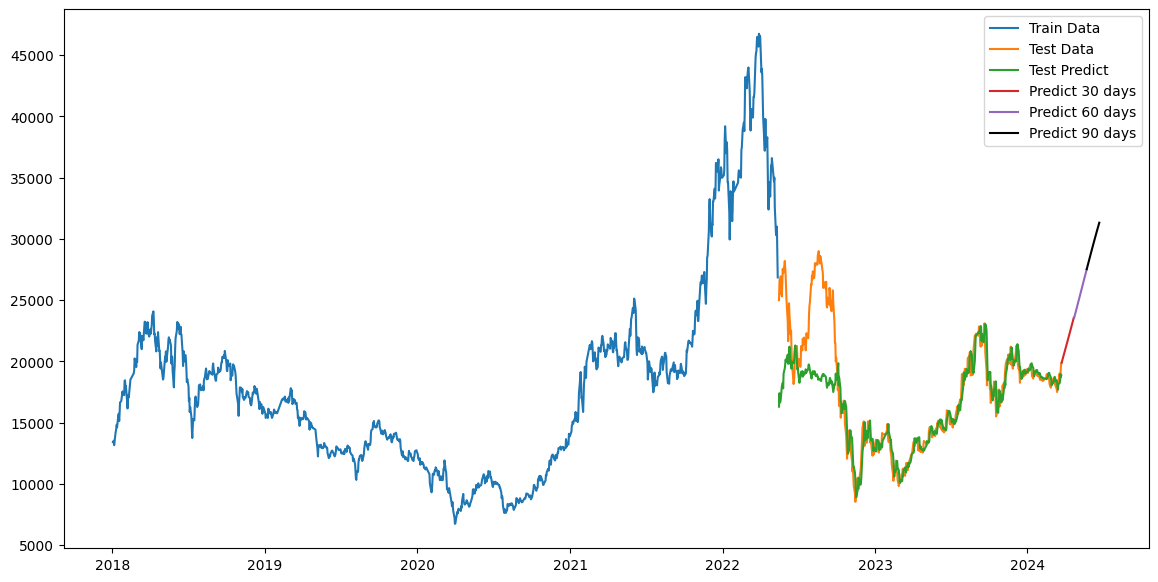

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()